### Enviroment preparation

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import numpy as np
import pandas as pd
import random
import time as t
import os
import re
import gc
from subprocess import Popen
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
ControlSparkCluster('stop')

cluster stopped


In [2]:
def ControlSparkCluster(action):
    if action == 'start':
        Popen('./start_cluster.sh',shell=True)
        t.sleep(10)
        print 'cluster started'
    elif action == 'stop':
        Popen('./stop_cluster.sh',shell=True)
        sc.stop()
        t.sleep(3)
        print 'cluster stopped'
    else:
        raise Exception('Unsupported command!')

In [3]:
ControlSparkCluster('start')

cluster started


In [4]:
conf = SparkConf().setMaster("spark://cathome:7077").setAppName("dpl")\
.setAll((['spark.executor.cores','4']
        ,['spark.driver.cores','4']
        ,['spark.driver.memory','1g']
        ,['spark.driver.maxResultSize','4g']
        ,['spark.executor.memory','1g']
        ,['spark.python.worker.memory','1g']
        ,['spark.default.parallelism','4']
       ))

In [5]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

### Data preparation

In [6]:
dir_name = '../../../diploma_data'

In [7]:
tr_num_file_name = 'train_numeric.csv'
tr_date_file_name = 'train_date.csv'
tr_cat_file_name = 'train_categorical.csv'

In [9]:
tr_num_data_file = '{0}/{1}'.format(dir_name,tr_num_file_name)
tr_date_data_file = '{0}/{1}'.format(dir_name,tr_date_file_name)
tr_cat_data_file = '{0}/{1}'.format(dir_name,tr_cat_file_name)

In [ ]:
%%time
df_num = sqlContext.read.csv(tr_num_data_file, sep=',', header=True, inferSchema=True)
df_date = sqlContext.read.csv(tr_date_data_file, sep=',', header=True, inferSchema=True)
df_cat = sqlContext.read.csv(tr_cat_data_file, sep=',', header=True, inferSchema=True)

### Data analisys/Data transformation

In [57]:
df_num2 = df_num
df_date2 = df_date
df_cat2 = df_cat

In [9]:
num_sample_file = '{0}/{1}'.format(dir_name,'num_sample.parquet')
date_sample_file = '{0}/{1}'.format(dir_name,'date_sample.parquet')
cat_sample_file = '{0}/{1}'.format(dir_name,'cat_sample.parquet')

In [ ]:
#df_num.sample(False, 0.02, seed=112).repartition(1024).write.parquet(num_sample_file)
#df_date.sample(False, 0.02, seed=112).repartition(1024).write.parquet(date_sample_file)
#df_cat.sample(False, 0.02, seed=112).repartition(4096).write.parquet(cat_sample_file)

In [82]:
%%time
df_num_smpl = sqlContext.read.parquet(num_sample_file)
df_date_smpl = sqlContext.read.parquet(date_sample_file)
#df_cat_smpl = sqlContext.read.csv(cat_sample_file, sep=',', header=True, inferSchema=True)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.33 s


In [12]:
pdf_date = df_date_smpl.toPandas()

In [79]:
cols_date = [(c.split('_')) for c in pdf_date.columns]
cols_date_df = pd.DataFrame(cols_date[1:], columns=['line','station','feature'])
cols_date_df['full_name'] = cols_date_df.line + '_' + cols_date_df.station + '_' + cols_date_df.feature
cols_date_df = cols_date_df.drop('line',1)
for i in list(cols_date_df.station.unique()):
    station_features = list(cols_date_df.loc[cols_date_df['station'] == i].full_name.values)
    pdf_date[station_features].corr(method='pearson')

,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,L0_S0_D21,L0_S0_D23
L0_S0_D1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S0_D19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S1_D26,L0_S1_D30
L0_S1_D26,1.0,1.0
L0_S1_D30,1.0,1.0


,L0_S2_D34,L0_S2_D38,L0_S2_D42,L0_S2_D46,L0_S2_D50,L0_S2_D54,L0_S2_D58,L0_S2_D62,L0_S2_D66
L0_S2_D34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D38,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D42,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D46,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D54,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D62,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S2_D66,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S3_D70,L0_S3_D74,L0_S3_D78,L0_S3_D82,L0_S3_D86,L0_S3_D90,L0_S3_D94,L0_S3_D98,L0_S3_D102
L0_S3_D70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D78,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D82,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D86,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D90,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S3_D102,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S4_D106,L0_S4_D111
L0_S4_D106,1.0,1.0
L0_S4_D111,1.0,1.0


,L0_S5_D115,L0_S5_D117
L0_S5_D115,1.0,1.0
L0_S5_D117,1.0,1.0


,L0_S6_D120,L0_S6_D124,L0_S6_D127,L0_S6_D130,L0_S6_D134
L0_S6_D120,1.0,1.0,1.0,1.0,1.0
L0_S6_D124,1.0,1.0,1.0,1.0,1.0
L0_S6_D127,1.0,1.0,1.0,1.0,1.0
L0_S6_D130,1.0,1.0,1.0,1.0,1.0
L0_S6_D134,1.0,1.0,1.0,1.0,1.0


,L0_S7_D137,L0_S7_D139,L0_S7_D140,L0_S7_D141,L0_S7_D143
L0_S7_D137,1.0,1.0,1.0,1.0,1.0
L0_S7_D139,1.0,1.0,1.0,1.0,1.0
L0_S7_D140,1.0,1.0,1.0,1.0,1.0
L0_S7_D141,1.0,1.0,1.0,1.0,1.0
L0_S7_D143,1.0,1.0,1.0,1.0,1.0


,L0_S8_D145,L0_S8_D147,L0_S8_D148,L0_S8_D150
L0_S8_D145,1.0,1.0,1.0,1.0
L0_S8_D147,1.0,1.0,1.0,1.0
L0_S8_D148,1.0,1.0,1.0,1.0
L0_S8_D150,1.0,1.0,1.0,1.0


,L0_S9_D152,L0_S9_D157,L0_S9_D162,L0_S9_D167,L0_S9_D172,L0_S9_D177,L0_S9_D182,L0_S9_D187,L0_S9_D192,L0_S9_D197,L0_S9_D202,L0_S9_D207,L0_S9_D212
L0_S9_D152,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D157,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D162,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D172,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D177,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D182,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D187,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D192,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S9_D197,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S10_D216,L0_S10_D221,L0_S10_D226,L0_S10_D231,L0_S10_D236,L0_S10_D241,L0_S10_D246,L0_S10_D251,L0_S10_D256,L0_S10_D261,L0_S10_D266,L0_S10_D271,L0_S10_D276
L0_S10_D216,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D221,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D226,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D231,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D236,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D241,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D246,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D251,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D256,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S10_D261,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S11_D280,L0_S11_D284,L0_S11_D288,L0_S11_D292,L0_S11_D296,L0_S11_D300,L0_S11_D304,L0_S11_D308,L0_S11_D312,L0_S11_D316,L0_S11_D320,L0_S11_D324,L0_S11_D328
L0_S11_D280,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D284,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D288,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D300,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D304,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D308,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D312,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S11_D316,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S12_D331,L0_S12_D333,L0_S12_D335,L0_S12_D337,L0_S12_D339,L0_S12_D341,L0_S12_D343,L0_S12_D345,L0_S12_D347,L0_S12_D349,L0_S12_D351,L0_S12_D353
L0_S12_D331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D337,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D339,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D341,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D343,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D345,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D347,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S12_D349,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S13_D355,L0_S13_D357
L0_S13_D355,1.0,1.0
L0_S13_D357,1.0,1.0


,L0_S14_D360,L0_S14_D364,L0_S14_D368,L0_S14_D372,L0_S14_D376,L0_S14_D380,L0_S14_D384,L0_S14_D388,L0_S14_D392
L0_S14_D360,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D368,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D372,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D376,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D380,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D384,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D388,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S14_D392,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S15_D395,L0_S15_D398,L0_S15_D401,L0_S15_D404,L0_S15_D407,L0_S15_D410,L0_S15_D413,L0_S15_D416,L0_S15_D419
L0_S15_D395,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D401,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D404,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D407,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D410,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D413,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D416,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S15_D419,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S16_D423,L0_S16_D428
L0_S16_D423,1.0,1.0
L0_S16_D428,1.0,1.0


,L0_S17_D432,L0_S17_D434
L0_S17_D432,1.0,1.0
L0_S17_D434,1.0,1.0


,L0_S18_D437,L0_S18_D441,L0_S18_D444,L0_S18_D447,L0_S18_D451
L0_S18_D437,1.0,1.0,1.0,1.0,1.0
L0_S18_D441,1.0,1.0,1.0,1.0,1.0
L0_S18_D444,1.0,1.0,1.0,1.0,1.0
L0_S18_D447,1.0,1.0,1.0,1.0,1.0
L0_S18_D451,1.0,1.0,1.0,1.0,1.0


,L0_S19_D454,L0_S19_D456,L0_S19_D457,L0_S19_D458,L0_S19_D460
L0_S19_D454,1.0,1.0,1.0,1.0,1.0
L0_S19_D456,1.0,1.0,1.0,1.0,1.0
L0_S19_D457,1.0,1.0,1.0,1.0,1.0
L0_S19_D458,1.0,1.0,1.0,1.0,1.0
L0_S19_D460,1.0,1.0,1.0,1.0,1.0


,L0_S20_D462,L0_S20_D464,L0_S20_D465,L0_S20_D467
L0_S20_D462,1.0,1.0,1.0,1.0
L0_S20_D464,1.0,1.0,1.0,1.0
L0_S20_D465,1.0,1.0,1.0,1.0
L0_S20_D467,1.0,1.0,1.0,1.0


,L0_S21_D469,L0_S21_D474,L0_S21_D479,L0_S21_D484,L0_S21_D489,L0_S21_D494,L0_S21_D499,L0_S21_D504,L0_S21_D509,L0_S21_D514,L0_S21_D519,L0_S21_D524,L0_S21_D529,L0_S21_D534,L0_S21_D539
L0_S21_D469,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D474,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D479,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D484,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D489,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D494,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D499,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D504,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D509,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S21_D514,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S22_D543,L0_S22_D548,L0_S22_D553,L0_S22_D558,L0_S22_D563,L0_S22_D568,L0_S22_D573,L0_S22_D578,L0_S22_D583,L0_S22_D588,L0_S22_D593,L0_S22_D598,L0_S22_D603,L0_S22_D608,L0_S22_D613
L0_S22_D543,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D548,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D553,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D558,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D563,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D568,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D573,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D578,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D583,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S22_D588,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L0_S23_D617,L0_S23_D621,L0_S23_D625,L0_S23_D629,L0_S23_D633,L0_S23_D637,L0_S23_D641,L0_S23_D645,L0_S23_D649,L0_S23_D653,L0_S23_D657,L0_S23_D661,L0_S23_D665,L0_S23_D669,L0_S23_D673
L0_S23_D617,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D621,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D625,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D629,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D633,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D637,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D641,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D645,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D649,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L0_S23_D653,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L1_S24_D677,L1_S24_D681,L1_S24_D685,L1_S24_D689,L1_S24_D693,L1_S24_D697,L1_S24_D702,L1_S24_D707,L1_S24_D712,L1_S24_D716,...,L1_S24_D1833,L1_S24_D1835,L1_S24_D1837,L1_S24_D1839,L1_S24_D1841,L1_S24_D1843,L1_S24_D1845,L1_S24_D1847,L1_S24_D1849,L1_S24_D1851
L1_S24_D677,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D681,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D685,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D689,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D693,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D697,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
L1_S24_D702,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D707,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D712,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727,0.997727
L1_S24_D716,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,L1_S25_D1854,L1_S25_D1857,L1_S25_D1860,L1_S25_D1862,L1_S25_D1864,L1_S25_D1867,L1_S25_D1871,L1_S25_D1875,L1_S25_D1879,L1_S25_D1883,...,L1_S25_D3018,L1_S25_D3019,L1_S25_D3021,L1_S25_D3023,L1_S25_D3025,L1_S25_D3027,L1_S25_D3029,L1_S25_D3031,L1_S25_D3033,L1_S25_D3035
L1_S25_D1854,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1857,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1860,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1862,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1864,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1867,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1871,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1875,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1879,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114
L1_S25_D1883,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114,0.999114


,L2_S26_D3037,L2_S26_D3041,L2_S26_D3044,L2_S26_D3048,L2_S26_D3052,L2_S26_D3056,L2_S26_D3059,L2_S26_D3063,L2_S26_D3066,L2_S26_D3070,...,L2_S26_D3093,L2_S26_D3096,L2_S26_D3100,L2_S26_D3103,L2_S26_D3107,L2_S26_D3110,L2_S26_D3114,L2_S26_D3118,L2_S26_D3122,L2_S26_D3126
L2_S26_D3037,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3041,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3044,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3048,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3052,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3056,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3059,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3063,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3066,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S26_D3070,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L2_S27_D3130,L2_S27_D3134,L2_S27_D3137,L2_S27_D3141,L2_S27_D3145,L2_S27_D3149,L2_S27_D3152,L2_S27_D3156,L2_S27_D3159,L2_S27_D3163,...,L2_S27_D3186,L2_S27_D3189,L2_S27_D3193,L2_S27_D3196,L2_S27_D3200,L2_S27_D3203,L2_S27_D3207,L2_S27_D3211,L2_S27_D3215,L2_S27_D3219
L2_S27_D3130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3134,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3137,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3141,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3145,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3149,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3152,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3156,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3159,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S27_D3163,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L2_S28_D3223,L2_S28_D3227,L2_S28_D3230,L2_S28_D3234,L2_S28_D3238,L2_S28_D3242,L2_S28_D3245,L2_S28_D3249,L2_S28_D3252,L2_S28_D3256,...,L2_S28_D3279,L2_S28_D3282,L2_S28_D3286,L2_S28_D3289,L2_S28_D3293,L2_S28_D3296,L2_S28_D3300,L2_S28_D3304,L2_S28_D3308,L2_S28_D3312
L2_S28_D3223,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3227,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3230,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3234,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3238,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3245,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3249,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3252,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L2_S28_D3256,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S29_D3316,L3_S29_D3319,L3_S29_D3322,L3_S29_D3325,L3_S29_D3328,L3_S29_D3331,L3_S29_D3334,L3_S29_D3337,L3_S29_D3340,L3_S29_D3343,...,L3_S29_D3465,L3_S29_D3468,L3_S29_D3471,L3_S29_D3474,L3_S29_D3477,L3_S29_D3480,L3_S29_D3483,L3_S29_D3486,L3_S29_D3489,L3_S29_D3492
L3_S29_D3316,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3319,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3322,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3325,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3328,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3334,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3337,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3340,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S29_D3343,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S30_D3496,L3_S30_D3501,L3_S30_D3506,L3_S30_D3511,L3_S30_D3516,L3_S30_D3521,L3_S30_D3526,L3_S30_D3531,L3_S30_D3536,L3_S30_D3541,...,L3_S30_D3786,L3_S30_D3791,L3_S30_D3796,L3_S30_D3801,L3_S30_D3806,L3_S30_D3811,L3_S30_D3816,L3_S30_D3821,L3_S30_D3826,L3_S30_D3831
L3_S30_D3496,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3501,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3506,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3511,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3516,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3521,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3526,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3531,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S30_D3541,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S31_D3836,L3_S31_D3840,L3_S31_D3844,L3_S31_D3848
L3_S31_D3836,1.0,1.0,1.0,1.0
L3_S31_D3840,1.0,1.0,1.0,1.0
L3_S31_D3844,1.0,1.0,1.0,1.0
L3_S31_D3848,1.0,1.0,1.0,1.0


,L3_S32_D3852
L3_S32_D3852,1.0


,L3_S33_D3856,L3_S33_D3858,L3_S33_D3860,L3_S33_D3862,L3_S33_D3864,L3_S33_D3866,L3_S33_D3868,L3_S33_D3870,L3_S33_D3872,L3_S33_D3874
L3_S33_D3856,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3858,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3860,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3862,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3864,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3866,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3868,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3870,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3872,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S33_D3874,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S34_D3875,L3_S34_D3877,L3_S34_D3879,L3_S34_D3881,L3_S34_D3883
L3_S34_D3875,1.0,1.0,1.0,1.0,1.0
L3_S34_D3877,1.0,1.0,1.0,1.0,1.0
L3_S34_D3879,1.0,1.0,1.0,1.0,1.0
L3_S34_D3881,1.0,1.0,1.0,1.0,1.0
L3_S34_D3883,1.0,1.0,1.0,1.0,1.0


,L3_S35_D3886,L3_S35_D3891,L3_S35_D3895,L3_S35_D3897,L3_S35_D3900,L3_S35_D3905,L3_S35_D3910,L3_S35_D3915
L3_S35_D3886,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3891,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3897,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3900,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3905,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3910,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S35_D3915,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S36_D3919,L3_S36_D3921,L3_S36_D3923,L3_S36_D3925,L3_S36_D3928,L3_S36_D3932,L3_S36_D3936,L3_S36_D3940
L3_S36_D3919,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3921,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3923,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3925,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3928,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3932,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3936,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S36_D3940,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S37_D3942,L3_S37_D3943,L3_S37_D3945,L3_S37_D3947,L3_S37_D3949,L3_S37_D3951
L3_S37_D3942,1.0,1.0,1.0,1.0,1.0,1.0
L3_S37_D3943,1.0,1.0,1.0,1.0,1.0,1.0
L3_S37_D3945,1.0,1.0,1.0,1.0,1.0,1.0
L3_S37_D3947,1.0,1.0,1.0,1.0,1.0,1.0
L3_S37_D3949,1.0,1.0,1.0,1.0,1.0,1.0
L3_S37_D3951,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S38_D3953,L3_S38_D3957,L3_S38_D3961
L3_S38_D3953,1.0,1.0,1.0
L3_S38_D3957,1.0,1.0,1.0
L3_S38_D3961,1.0,1.0,1.0


,L3_S39_D3966,L3_S39_D3970,L3_S39_D3974,L3_S39_D3978
L3_S39_D3966,1.0,1.0,1.0,1.0
L3_S39_D3970,1.0,1.0,1.0,1.0
L3_S39_D3974,1.0,1.0,1.0,1.0
L3_S39_D3978,1.0,1.0,1.0,1.0


,L3_S40_D3981,L3_S40_D3983,L3_S40_D3985,L3_S40_D3987,L3_S40_D3989,L3_S40_D3991,L3_S40_D3993,L3_S40_D3995
L3_S40_D3981,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3983,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3985,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3987,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3989,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3991,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3993,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S40_D3995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S41_D3997,L3_S41_D3999,L3_S41_D4001,L3_S41_D4003,L3_S41_D4005,L3_S41_D4007,L3_S41_D4009,L3_S41_D4010,L3_S41_D4012,L3_S41_D4013,L3_S41_D4015,L3_S41_D4017,L3_S41_D4019,L3_S41_D4021,L3_S41_D4022,L3_S41_D4024,L3_S41_D4025,L3_S41_D4027
L3_S41_D3997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D3999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4009,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4010,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S41_D4013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S42_D4029,L3_S42_D4033,L3_S42_D4037,L3_S42_D4041,L3_S42_D4045,L3_S42_D4049,L3_S42_D4053,L3_S42_D4057
L3_S42_D4029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S42_D4057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,L3_S43_D4062,L3_S43_D4067,L3_S43_D4072,L3_S43_D4077,L3_S43_D4082,L3_S43_D4087,L3_S43_D4092,L3_S43_D4097
L3_S43_D4062,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4067,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4072,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4077,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4082,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4087,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4092,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S43_D4097,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S44_D4101,L3_S44_D4104,L3_S44_D4107,L3_S44_D4110,L3_S44_D4113,L3_S44_D4116,L3_S44_D4119,L3_S44_D4122
L3_S44_D4101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4110,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4113,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4116,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4119,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S44_D4122,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S45_D4125,L3_S45_D4127,L3_S45_D4129,L3_S45_D4131,L3_S45_D4133
L3_S45_D4125,1.0,1.0,1.0,1.0,1.0
L3_S45_D4127,1.0,1.0,1.0,1.0,1.0
L3_S45_D4129,1.0,1.0,1.0,1.0,1.0
L3_S45_D4131,1.0,1.0,1.0,1.0,1.0
L3_S45_D4133,1.0,1.0,1.0,1.0,1.0


""


,L3_S47_D4140,L3_S47_D4145,L3_S47_D4150,L3_S47_D4155,L3_S47_D4160,L3_S47_D4165,L3_S47_D4170,L3_S47_D4175,L3_S47_D4180,L3_S47_D4185,L3_S47_D4190
L3_S47_D4140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4145,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4150,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4155,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4160,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4165,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4170,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4175,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4180,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S47_D4185,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S48_D4194,L3_S48_D4195,L3_S48_D4197,L3_S48_D4199,L3_S48_D4201,L3_S48_D4203,L3_S48_D4205
L3_S48_D4194,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4195,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4197,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4199,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4201,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4203,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S48_D4205,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S49_D4208,L3_S49_D4213,L3_S49_D4218,L3_S49_D4223,L3_S49_D4228,L3_S49_D4233,L3_S49_D4238
L3_S49_D4208,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4213,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4218,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4223,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4228,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4233,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S49_D4238,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S50_D4242,L3_S50_D4244,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254
L3_S50_D4242,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4244,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4246,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4248,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4250,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4252,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L3_S50_D4254,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
L3_S51_D4255,1.0,1.0,1.0,1.0,1.0
L3_S51_D4257,1.0,1.0,1.0,1.0,1.0
L3_S51_D4259,1.0,1.0,1.0,1.0,1.0
L3_S51_D4261,1.0,1.0,1.0,1.0,1.0
L3_S51_D4263,1.0,1.0,1.0,1.0,1.0


In [83]:
pdf_num = df_num_smpl.toPandas()

In [106]:
useful_values = []
cols_date = [(c.split('_')) for c in pdf_num.columns]
cols_date_df = pd.DataFrame(cols_date[1:], columns=['line','station','feature'])
cols_date_df['full_name'] = cols_date_df.line + '_' + cols_date_df.station + '_' + cols_date_df.feature
cols_date_df = cols_date_df.drop('line',1)
for i in list(cols_date_df.station.unique()):
    station_features = list(cols_date_df.loc[cols_date_df['station'] == i].full_name.values)
    corr_df = pd.DataFrame(pdf_num[station_features].corr(method='pearson'))
    corr_df
    try:
        min_value = abs(corr_df.loc[:, station_features]).min(axis=1).idxmax(axis=0)
    except:
        min_value = None
    if min_value:
        useful_values.append(min_value)
useful_values

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22
L0_S0_F0,1.000000,0.889585,-0.024860,-0.023693,-0.021955,-0.016040,-0.778816,-0.699263,0.151366,0.206989,0.153013,0.153011
L0_S0_F2,0.889585,1.000000,-0.023703,-0.027373,-0.042980,0.012173,-0.689760,-0.778402,0.223214,0.176426,0.199401,0.199399
L0_S0_F4,-0.024860,-0.023703,1.000000,0.992738,-0.028634,0.049657,0.551105,0.552818,0.056977,0.046345,-0.013667,-0.013668
L0_S0_F6,-0.023693,-0.027373,0.992738,1.000000,-0.029508,0.049524,0.554599,0.551547,0.057959,0.044261,-0.012808,-0.012810
L0_S0_F8,-0.021955,-0.042980,-0.028634,-0.029508,1.000000,0.516884,-0.038238,-0.021610,0.042460,0.080503,-0.050112,-0.050098
L0_S0_F10,-0.016040,0.012173,0.049657,0.049524,0.516884,1.000000,0.038773,0.016819,0.220418,0.270935,-0.000579,-0.000578
L0_S0_F12,-0.778816,-0.689760,0.551105,0.554599,-0.038238,0.038773,1.000000,0.914613,-0.098344,-0.158758,-0.109484,-0.109484
L0_S0_F14,-0.699263,-0.778402,0.552818,0.551547,-0.021610,0.016819,0.914613,1.000000,-0.161912,-0.138369,-0.140083,-0.140083
L0_S0_F16,0.151366,0.223214,0.056977,0.057959,0.042460,0.220418,-0.098344,-0.161912,1.000000,0.607189,0.018838,0.018839
L0_S0_F18,0.206989,0.176426,0.046345,0.044261,0.080503,0.270935,-0.158758,-0.138369,0.607189,1.000000,0.023059,0.023059


,L0_S1_F24,L0_S1_F28
L0_S1_F24,1.00000,-0.26028
L0_S1_F28,-0.26028,1.00000


,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F52,L0_S2_F56,L0_S2_F60,L0_S2_F64
L0_S2_F32,1.000000,-0.336864,0.755147,-0.146511,0.294490,NaN,0.694501,0.032475,-0.114641
L0_S2_F36,-0.336864,1.000000,0.022725,0.017860,-0.005609,NaN,0.039810,-0.016953,0.017920
L0_S2_F40,0.755147,0.022725,1.000000,-0.600806,0.168338,NaN,0.595915,0.019304,-0.276755
L0_S2_F44,-0.146511,0.017860,-0.600806,1.000000,0.065475,NaN,-0.102562,-0.023918,0.187910
L0_S2_F48,0.294490,-0.005609,0.168338,0.065475,1.000000,NaN,0.211209,0.058574,0.005544
L0_S2_F52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S2_F56,0.694501,0.039810,0.595915,-0.102562,0.211209,NaN,1.000000,-0.584736,-0.020423
L0_S2_F60,0.032475,-0.016953,0.019304,-0.023918,0.058574,NaN,-0.584736,1.000000,-0.002484
L0_S2_F64,-0.114641,0.017920,-0.276755,0.187910,0.005544,NaN,-0.020423,-0.002484,1.000000


,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F88,L0_S3_F92,L0_S3_F96,L0_S3_F100
L0_S3_F68,1.000000,-0.535506,0.549338,0.007300,0.218603,NaN,0.774321,-0.216751,0.168749
L0_S3_F72,-0.535506,1.000000,0.097776,-0.120711,0.010810,NaN,-0.197121,0.376302,-0.072591
L0_S3_F76,0.549338,0.097776,1.000000,-0.643326,0.127415,NaN,0.574638,-0.035314,0.033173
L0_S3_F80,0.007300,-0.120711,-0.643326,1.000000,0.102952,NaN,-0.081360,-0.026104,-0.096592
L0_S3_F84,0.218603,0.010810,0.127415,0.102952,1.000000,NaN,0.148524,-0.004461,-0.065571
L0_S3_F88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S3_F92,0.774321,-0.197121,0.574638,-0.081360,0.148524,NaN,1.000000,-0.562679,0.263574
L0_S3_F96,-0.216751,0.376302,-0.035314,-0.026104,-0.004461,NaN,-0.562679,1.000000,-0.048765
L0_S3_F100,0.168749,-0.072591,0.033173,-0.096592,-0.065571,NaN,0.263574,-0.048765,1.000000


,L0_S4_F104,L0_S4_F109
L0_S4_F104,1.000000,0.294622
L0_S4_F109,0.294622,1.000000


,L0_S5_F114,L0_S5_F116
L0_S5_F114,1.00000,-0.05208
L0_S5_F116,-0.05208,1.00000


,L0_S6_F118,L0_S6_F122,L0_S6_F132
L0_S6_F118,1.000000,-0.832089,0.174149
L0_S6_F122,-0.832089,1.000000,0.020615
L0_S6_F132,0.174149,0.020615,1.000000


,L0_S7_F136,L0_S7_F138,L0_S7_F142
L0_S7_F136,1.000000,-0.909036,0.262279
L0_S7_F138,-0.909036,1.000000,-0.238620
L0_S7_F142,0.262279,-0.238620,1.000000


,L0_S8_F144,L0_S8_F146,L0_S8_F149
L0_S8_F144,1.000000,0.000818,0.001207
L0_S8_F146,0.000818,1.000000,-0.770124
L0_S8_F149,0.001207,-0.770124,1.000000


,L0_S9_F155,L0_S9_F160,L0_S9_F165,L0_S9_F170,L0_S9_F175,L0_S9_F180,L0_S9_F185,L0_S9_F190,L0_S9_F195,L0_S9_F200,L0_S9_F205,L0_S9_F210
L0_S9_F155,1.000000,0.054169,0.217615,0.139358,0.321604,0.365922,0.178064,0.112636,0.352234,0.096074,0.184984,0.078102
L0_S9_F160,0.054169,1.000000,0.022578,-0.288842,-0.123908,-0.116262,0.190078,-0.266179,0.068801,0.239137,-0.116472,0.053037
L0_S9_F165,0.217615,0.022578,1.000000,0.016780,0.169524,0.196716,-0.016092,0.088626,0.115175,-0.060444,0.106764,0.059487
L0_S9_F170,0.139358,-0.288842,0.016780,1.000000,0.138694,0.143668,0.200637,-0.042501,0.225735,0.174999,0.075690,-0.001935
L0_S9_F175,0.321604,-0.123908,0.169524,0.138694,1.000000,0.971634,0.331164,0.724265,0.190934,0.100494,0.624309,0.367933
L0_S9_F180,0.365922,-0.116262,0.196716,0.143668,0.971634,1.000000,0.357449,0.731933,0.254073,0.125136,0.658085,0.408167
L0_S9_F185,0.178064,0.190078,-0.016092,0.200637,0.331164,0.357449,1.000000,0.075715,0.554417,0.960467,0.211443,0.197190
L0_S9_F190,0.112636,-0.266179,0.088626,-0.042501,0.724265,0.731933,0.075715,1.000000,-0.112519,-0.120275,0.567633,0.331298
L0_S9_F195,0.352234,0.068801,0.115175,0.225735,0.190934,0.254073,0.554417,-0.112519,1.000000,0.543741,0.103313,0.137618
L0_S9_F200,0.096074,0.239137,-0.060444,0.174999,0.100494,0.125136,0.960467,-0.120275,0.543741,1.000000,0.054599,0.206450


,L0_S10_F219,L0_S10_F224,L0_S10_F229,L0_S10_F234,L0_S10_F239,L0_S10_F244,L0_S10_F249,L0_S10_F254,L0_S10_F259,L0_S10_F264,L0_S10_F269,L0_S10_F274
L0_S10_F219,1.000000,-0.106403,0.418244,0.013271,0.275511,0.286271,0.249011,-0.111510,0.368374,0.143737,0.001443,-0.098098
L0_S10_F224,-0.106403,1.000000,-0.136518,-0.566334,-0.135603,-0.134531,-0.237943,0.136199,-0.158940,-0.199255,0.008163,-0.008226
L0_S10_F229,0.418244,-0.136518,1.000000,0.066944,0.107407,0.111194,0.112032,-0.180732,0.203554,0.064099,0.002847,-0.126440
L0_S10_F234,0.013271,-0.566334,0.066944,1.000000,0.106515,0.105120,0.347286,-0.035005,-0.100281,0.310807,-0.002215,-0.004952
L0_S10_F239,0.275511,-0.135603,0.107407,0.106515,1.000000,0.985036,0.466027,0.420966,0.102502,0.160529,0.033681,0.391059
L0_S10_F244,0.286271,-0.134531,0.111194,0.105120,0.985036,1.000000,0.468331,0.420689,0.110303,0.158857,0.032914,0.404088
L0_S10_F249,0.249011,-0.237943,0.112032,0.347286,0.466027,0.468331,1.000000,0.088859,0.239872,0.881110,0.009197,0.186837
L0_S10_F254,-0.111510,0.136199,-0.180732,-0.035005,0.420966,0.420689,0.088859,1.000000,-0.222687,-0.067282,0.022843,0.222116
L0_S10_F259,0.368374,-0.158940,0.203554,-0.100281,0.102502,0.110303,0.239872,-0.222687,1.000000,0.234334,-0.004200,-0.000234
L0_S10_F264,0.143737,-0.199255,0.064099,0.310807,0.160529,0.158857,0.881110,-0.067282,0.234334,1.000000,0.282542,0.197536


,L0_S11_F282,L0_S11_F286,L0_S11_F290,L0_S11_F294,L0_S11_F298,L0_S11_F302,L0_S11_F306,L0_S11_F310,L0_S11_F314,L0_S11_F318,L0_S11_F322,L0_S11_F326
L0_S11_F282,1.000000,0.022985,0.472617,-0.059260,0.508390,0.551800,0.462309,0.012637,0.540733,0.327603,0.379931,0.414057
L0_S11_F286,0.022985,1.000000,-0.049889,-0.563044,-0.082072,-0.072436,-0.203864,-0.319113,-0.030772,-0.168325,-0.127936,0.101536
L0_S11_F290,0.472617,-0.049889,1.000000,0.034717,0.385719,0.416996,0.358550,0.108230,0.374553,0.250792,0.303463,0.309793
L0_S11_F294,-0.059260,-0.563044,0.034717,1.000000,0.053095,0.049352,0.255456,0.404693,0.000768,0.225342,0.131020,-0.070959
L0_S11_F298,0.508390,-0.082072,0.385719,0.053095,1.000000,0.979926,0.517173,0.554953,0.108877,0.124957,0.902866,0.026950
L0_S11_F302,0.551800,-0.072436,0.416996,0.049352,0.979926,1.000000,0.542761,0.546150,0.156137,0.150722,0.908875,0.118967
L0_S11_F306,0.462309,-0.203864,0.358550,0.255456,0.517173,0.542761,1.000000,0.236252,0.403563,0.892697,0.471458,0.206074
L0_S11_F310,0.012637,-0.319113,0.108230,0.404693,0.554953,0.546150,0.236252,1.000000,-0.336551,-0.070637,0.669875,-0.161693
L0_S11_F314,0.540733,-0.030772,0.374553,0.000768,0.108877,0.156137,0.403563,-0.336551,1.000000,0.464742,-0.022563,0.518023
L0_S11_F318,0.327603,-0.168325,0.250792,0.225342,0.124957,0.150722,0.892697,-0.070637,0.464742,1.000000,0.024271,0.253531


,L0_S12_F330,L0_S12_F332,L0_S12_F334,L0_S12_F336,L0_S12_F338,L0_S12_F340,L0_S12_F342,L0_S12_F344,L0_S12_F346,L0_S12_F348,L0_S12_F350,L0_S12_F352
L0_S12_F330,1.000000,0.960399,-0.368330,-0.371791,-0.010593,-0.004853,-0.803853,-0.792222,0.432878,0.418658,0.155397,0.155393
L0_S12_F332,0.960399,1.000000,-0.350746,-0.349364,-0.027024,-0.009372,-0.771111,-0.799878,0.449332,0.426611,0.188192,0.188192
L0_S12_F334,-0.368330,-0.350746,1.000000,0.994440,0.045054,0.019738,0.838318,0.828668,-0.020971,-0.008426,0.058025,0.058031
L0_S12_F336,-0.371791,-0.349364,0.994440,1.000000,0.043433,0.019350,0.837124,0.830985,-0.022842,-0.009088,0.057308,0.057316
L0_S12_F338,-0.010593,-0.027024,0.045054,0.043433,1.000000,0.931721,0.036583,0.043312,-0.088707,-0.078759,0.048625,0.048623
L0_S12_F340,-0.004853,-0.009372,0.019738,0.019350,0.931721,1.000000,0.017266,0.016765,-0.116541,-0.136204,0.044969,0.044970
L0_S12_F342,-0.803853,-0.771111,0.838318,0.837124,0.036583,0.017266,1.000000,0.978798,-0.264490,-0.243265,-0.053200,-0.053195
L0_S12_F344,-0.792222,-0.799878,0.828668,0.830985,0.043312,0.016765,0.978798,1.000000,-0.278014,-0.251386,-0.073540,-0.073534
L0_S12_F346,0.432878,0.449332,-0.020971,-0.022842,-0.088707,-0.116541,-0.264490,-0.278014,1.000000,0.669547,-0.029494,-0.029490
L0_S12_F348,0.418658,0.426611,-0.008426,-0.009088,-0.078759,-0.136204,-0.243265,-0.251386,0.669547,1.000000,0.006233,0.006233


,L0_S13_F354,L0_S13_F356
L0_S13_F354,1.000000,-0.277129
L0_S13_F356,-0.277129,1.000000


,L0_S14_F358,L0_S14_F362,L0_S14_F366,L0_S14_F370,L0_S14_F374,L0_S14_F378,L0_S14_F382,L0_S14_F386,L0_S14_F390
L0_S14_F358,1.000000,-0.731285,0.600284,-0.082577,-0.015385,NaN,0.774818,-0.319692,0.401872
L0_S14_F362,-0.731285,1.000000,-0.115370,-0.022950,-0.059303,NaN,-0.444167,0.427929,-0.067575
L0_S14_F366,0.600284,-0.115370,1.000000,-0.633846,-0.221739,NaN,0.574977,-0.066338,0.517580
L0_S14_F370,-0.082577,-0.022950,-0.633846,1.000000,0.146061,NaN,-0.233434,0.082321,-0.339971
L0_S14_F374,-0.015385,-0.059303,-0.221739,0.146061,1.000000,NaN,0.005181,-0.137165,-0.278999
L0_S14_F378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S14_F382,0.774818,-0.444167,0.574977,-0.233434,0.005181,NaN,1.000000,-0.652088,0.454962
L0_S14_F386,-0.319692,0.427929,-0.066338,0.082321,-0.137165,NaN,-0.652088,1.000000,-0.042772
L0_S14_F390,0.401872,-0.067575,0.517580,-0.339971,-0.278999,NaN,0.454962,-0.042772,1.000000


,L0_S15_F394,L0_S15_F397,L0_S15_F400,L0_S15_F403,L0_S15_F406,L0_S15_F409,L0_S15_F412,L0_S15_F415,L0_S15_F418
L0_S15_F394,1.000000,-0.653103,0.554444,0.001157,0.067096,NaN,0.716133,-0.223521,0.128513
L0_S15_F397,-0.653103,1.000000,-0.023103,-0.081769,-0.095776,NaN,-0.312610,0.395667,0.036528
L0_S15_F400,0.554444,-0.023103,1.000000,-0.638082,-0.096894,NaN,0.435892,0.020359,0.197910
L0_S15_F403,0.001157,-0.081769,-0.638082,1.000000,0.109626,NaN,-0.011506,-0.012236,-0.109154
L0_S15_F406,0.067096,-0.095776,-0.096894,0.109626,1.000000,NaN,0.143986,-0.088403,-0.402558
L0_S15_F409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L0_S15_F412,0.716133,-0.312610,0.435892,-0.011506,0.143986,NaN,1.000000,-0.638572,0.068587
L0_S15_F415,-0.223521,0.395667,0.020359,-0.012236,-0.088403,NaN,-0.638572,1.000000,0.115851
L0_S15_F418,0.128513,0.036528,0.197910,-0.109154,-0.402558,NaN,0.068587,0.115851,1.000000


,L0_S16_F421,L0_S16_F426
L0_S16_F421,1.000000,0.058657
L0_S16_F426,0.058657,1.000000


,L0_S17_F431,L0_S17_F433
L0_S17_F431,1.000000,0.497518
L0_S17_F433,0.497518,1.000000


,L0_S18_F435,L0_S18_F439,L0_S18_F449
L0_S18_F435,1.000000,-0.565135,-0.004778
L0_S18_F439,-0.565135,1.000000,-0.145344
L0_S18_F449,-0.004778,-0.145344,1.000000


,L0_S19_F453,L0_S19_F455,L0_S19_F459
L0_S19_F453,1.000000,-0.609803,-0.058415
L0_S19_F455,-0.609803,1.000000,-0.000966
L0_S19_F459,-0.058415,-0.000966,1.000000


,L0_S20_F461,L0_S20_F463,L0_S20_F466
L0_S20_F461,1.000000,-0.007152,0.007548
L0_S20_F463,-0.007152,1.000000,-0.998442
L0_S20_F466,0.007548,-0.998442,1.000000


,L0_S21_F472,L0_S21_F477,L0_S21_F482,L0_S21_F487,L0_S21_F492,L0_S21_F497,L0_S21_F502,L0_S21_F507,L0_S21_F512,L0_S21_F517,L0_S21_F522,L0_S21_F527,L0_S21_F532,L0_S21_F537
L0_S21_F472,1.000000,-0.158694,0.642577,0.108441,0.578831,0.551800,0.365794,0.305444,0.652341,0.108912,0.461953,0.228923,0.472444,-0.419470
L0_S21_F477,-0.158694,1.000000,-0.170544,-0.440011,-0.146006,-0.154773,-0.019271,-0.055698,-0.222887,-0.112940,-0.435552,0.021146,-0.132247,0.005495
L0_S21_F482,0.642577,-0.170544,1.000000,0.116462,0.575063,0.552244,0.302696,0.261140,0.515566,0.186412,0.388630,0.158913,0.488855,-0.344440
L0_S21_F487,0.108441,-0.440011,0.116462,1.000000,0.150070,0.161516,0.280593,0.042505,0.077489,0.082437,0.123483,0.246314,0.131864,-0.033567
L0_S21_F492,0.578831,-0.146006,0.575063,0.150070,1.000000,0.975594,0.301353,0.171010,0.254765,0.657808,0.142068,0.020982,0.917450,-0.188259
L0_S21_F497,0.551800,-0.154773,0.552244,0.161516,0.975594,1.000000,0.281025,0.154151,0.200740,0.717516,0.115849,-0.005294,0.934518,-0.069611
L0_S21_F502,0.365794,-0.019271,0.302696,0.280593,0.301353,0.281025,1.000000,0.138857,0.281857,-0.033590,0.126368,0.951643,0.256821,-0.291184
L0_S21_F507,0.305444,-0.055698,0.261140,0.042505,0.171010,0.154151,0.138857,1.000000,0.433156,-0.140803,0.346435,0.108361,0.111444,-0.159633
L0_S21_F512,0.652341,-0.222887,0.515566,0.077489,0.254765,0.200740,0.281857,0.433156,1.000000,-0.255687,0.706762,0.247873,0.140001,-0.509749
L0_S21_F517,0.108912,-0.112940,0.186412,0.082437,0.657808,0.717516,-0.033590,-0.140803,-0.255687,1.000000,-0.222436,-0.269359,0.747397,0.280427


,L0_S22_F546,L0_S22_F551,L0_S22_F556,L0_S22_F561,L0_S22_F566,L0_S22_F571,L0_S22_F576,L0_S22_F581,L0_S22_F586,L0_S22_F591,L0_S22_F596,L0_S22_F601,L0_S22_F606,L0_S22_F611
L0_S22_F546,1.000000,0.093773,0.785012,-0.102226,0.342889,0.353483,0.081352,-0.009392,-0.091055,-0.173476,-0.045199,-0.007654,0.343406,0.096273
L0_S22_F551,0.093773,1.000000,0.098606,-0.563567,-0.147925,-0.157991,0.008308,0.073091,-0.107868,-0.056685,-0.036530,0.040166,-0.112981,-0.015661
L0_S22_F556,0.785012,0.098606,1.000000,-0.091268,0.327122,0.335090,0.094192,-0.007095,-0.095018,-0.190983,-0.062607,0.007508,0.338544,0.086330
L0_S22_F561,-0.102226,-0.563567,-0.091268,1.000000,0.073129,0.076779,-0.050017,-0.035838,-0.057113,0.118493,-0.115850,-0.061538,0.040971,-0.068824
L0_S22_F566,0.342889,-0.147925,0.327122,0.073129,1.000000,0.980830,0.273870,0.102341,0.213657,0.307577,0.084812,0.033012,0.912543,-0.025173
L0_S22_F571,0.353483,-0.157991,0.335090,0.076779,0.980830,1.000000,0.282791,0.103324,0.230311,0.316788,0.104665,0.039269,0.921888,0.056723
L0_S22_F576,0.081352,0.008308,0.094192,-0.050017,0.273870,0.282791,1.000000,0.232844,0.556215,-0.113632,0.485347,0.964502,0.145029,0.041446
L0_S22_F581,-0.009392,0.073091,-0.007095,-0.035838,0.102341,0.103324,0.232844,1.000000,0.234435,-0.152016,0.234849,0.225775,0.033290,0.016753
L0_S22_F586,-0.091055,-0.107868,-0.095018,-0.057113,0.213657,0.230311,0.556215,0.234435,1.000000,-0.174555,0.822363,0.540310,0.047853,0.134437
L0_S22_F591,-0.173476,-0.056685,-0.190983,0.118493,0.307577,0.316788,-0.113632,-0.152016,-0.174555,1.000000,-0.048268,-0.212332,0.378317,-0.037945


,L0_S23_F619,L0_S23_F623,L0_S23_F627,L0_S23_F631,L0_S23_F635,L0_S23_F639,L0_S23_F643,L0_S23_F647,L0_S23_F651,L0_S23_F655,L0_S23_F659,L0_S23_F663,L0_S23_F667,L0_S23_F671
L0_S23_F619,1.000000,0.100847,0.702743,0.112024,0.629297,0.642611,0.329168,-0.023763,0.662494,0.255059,0.559590,0.148005,0.519486,-0.028638
L0_S23_F623,0.100847,1.000000,0.012253,-0.439703,-0.162891,-0.172070,0.334436,0.002866,0.221847,-0.122345,-0.048555,0.408788,-0.202048,-0.016201
L0_S23_F627,0.702743,0.012253,1.000000,0.113865,0.591192,0.606499,0.268074,-0.018969,0.481772,0.250679,0.530125,0.103007,0.475364,-0.027556
L0_S23_F631,0.112024,-0.439703,0.113865,1.000000,0.189776,0.193494,0.094174,0.024785,0.007960,0.077216,0.060211,0.032656,0.169445,-0.021327
L0_S23_F635,0.629297,-0.162891,0.591192,0.189776,1.000000,0.976315,0.224372,0.072518,0.167613,0.424591,0.165193,-0.098333,0.922269,-0.133508
L0_S23_F639,0.642611,-0.172070,0.606499,0.193494,0.976315,1.000000,0.217517,0.049439,0.175430,0.448954,0.174643,-0.108799,0.933094,-0.010673
L0_S23_F643,0.329168,0.334436,0.268074,0.094174,0.224372,0.217517,1.000000,0.089281,0.384960,0.064138,0.114750,0.938116,0.180104,-0.146995
L0_S23_F647,-0.023763,0.002866,-0.018969,0.024785,0.072518,0.049439,0.089281,1.000000,-0.024614,-0.063794,-0.019781,0.072046,0.059694,-0.139497
L0_S23_F651,0.662494,0.221847,0.481772,0.007960,0.167613,0.175430,0.384960,-0.024614,1.000000,0.042864,0.752523,0.372214,0.040188,0.016788
L0_S23_F655,0.255059,-0.122345,0.250679,0.077216,0.424591,0.448954,0.064138,-0.063794,0.042864,1.000000,0.059192,-0.093973,0.450122,0.063268


,L1_S24_F679,L1_S24_F683,L1_S24_F687,L1_S24_F691,L1_S24_F700,L1_S24_F719,L1_S24_F728,L1_S24_F733,L1_S24_F746,L1_S24_F751,...,L1_S24_F1831,L1_S24_F1834,L1_S24_F1836,L1_S24_F1838,L1_S24_F1840,L1_S24_F1842,L1_S24_F1844,L1_S24_F1846,L1_S24_F1848,L1_S24_F1850
L1_S24_F679,1.000000,-0.044278,0.166714,-0.083825,-0.046856,-0.165699,0.380242,0.411212,-0.172161,NaN,...,1.000000,1.000000,1.000000,1.000000,NaN,-1.000000,-1.000000,1.000000,-1.000000,1.000000
L1_S24_F683,-0.044278,1.000000,0.324377,0.010859,0.031880,-0.178574,-0.054755,0.040005,-0.163664,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,NaN,1.000000,1.000000,-1.000000,1.000000,-1.000000
L1_S24_F687,0.166714,0.324377,1.000000,-0.162774,-0.132444,-0.003297,0.105943,0.017861,-0.003615,NaN,...,1.000000,1.000000,1.000000,1.000000,NaN,-1.000000,-1.000000,1.000000,-1.000000,1.000000
L1_S24_F691,-0.083825,0.010859,-0.162774,1.000000,0.019967,0.123332,-0.047631,-0.067554,0.124759,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,NaN,1.000000,1.000000,-1.000000,1.000000,-1.000000
L1_S24_F700,-0.046856,0.031880,-0.132444,0.019967,1.000000,-0.237234,-0.024812,0.104371,-0.237167,NaN,...,1.000000,1.000000,1.000000,1.000000,NaN,-1.000000,-1.000000,1.000000,-1.000000,1.000000
L1_S24_F719,-0.165699,-0.178574,-0.003297,0.123332,-0.237234,1.000000,-0.046715,-0.139472,0.997303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1_S24_F728,0.380242,-0.054755,0.105943,-0.047631,-0.024812,-0.046715,1.000000,-0.648518,-0.048756,NaN,...,1.000000,1.000000,1.000000,1.000000,NaN,-1.000000,-1.000000,1.000000,-1.000000,1.000000
L1_S24_F733,0.411212,0.040005,0.017861,-0.067554,0.104371,-0.139472,-0.648518,1.000000,-0.141186,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,NaN,1.000000,1.000000,-1.000000,1.000000,-1.000000
L1_S24_F746,-0.172161,-0.163664,-0.003615,0.124759,-0.237167,0.997303,-0.048756,-0.141186,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1_S24_F751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,L1_S25_F1855,L1_S25_F1858,L1_S25_F1865,L1_S25_F1869,L1_S25_F1873,L1_S25_F1877,L1_S25_F1881,L1_S25_F1885,L1_S25_F1890,L1_S25_F1892,...,L1_S25_F3015,L1_S25_F3017,L1_S25_F3020,L1_S25_F3022,L1_S25_F3024,L1_S25_F3026,L1_S25_F3028,L1_S25_F3030,L1_S25_F3032,L1_S25_F3034
L1_S25_F1855,1.000000,-0.014905,0.034602,0.519721,0.401084,0.863019,0.007426,-0.065030,0.091651,0.095033,...,0.473241,0.479198,-0.400079,-0.469399,-0.006394,0.655540,0.607299,-0.479707,0.465970,0.032696
L1_S25_F1858,-0.014905,1.000000,-0.253592,-0.024082,0.039905,-0.007447,-0.031581,0.035177,-0.024403,-0.024729,...,-0.236383,0.439497,-0.353485,-0.260280,-0.166223,0.264653,0.263134,-0.232530,-0.237140,-0.088972
L1_S25_F1865,0.034602,-0.253592,1.000000,-0.065265,0.008219,0.051202,0.047009,0.052723,-0.027666,-0.024217,...,-0.305714,-0.106244,0.171122,0.299059,0.516076,0.103597,0.078062,-0.274800,-0.308388,0.078559
L1_S25_F1869,0.519721,-0.024082,-0.065265,1.000000,-0.071092,0.430670,-0.041416,-0.001790,-0.001261,-0.001433,...,-0.224437,0.088098,-0.629039,-0.585869,0.014121,0.602440,0.534786,-0.171470,-0.233564,0.288000
L1_S25_F1873,0.401084,0.039905,0.008219,-0.071092,1.000000,0.386686,0.014554,-0.052345,0.057814,0.060159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1_S25_F1877,0.863019,-0.007447,0.051202,0.430670,0.386686,1.000000,0.007337,-0.049582,0.068878,0.074595,...,0.567454,0.380710,-0.285956,-0.446647,-0.144437,0.480463,0.432144,-0.330508,0.560963,-0.140928
L1_S25_F1881,0.007426,-0.031581,0.047009,-0.041416,0.014554,0.007337,1.000000,-0.023664,0.022566,0.018855,...,0.053833,-0.307851,0.263584,0.293473,0.194734,-0.075791,-0.047889,-0.116831,0.056735,0.009177
L1_S25_F1885,-0.065030,0.035177,0.052723,-0.001790,-0.052345,-0.049582,-0.023664,1.000000,-0.932679,-0.937314,...,-0.276049,0.244144,0.359093,0.502851,0.342578,-0.059260,0.016775,-0.390960,-0.276258,0.077462
L1_S25_F1890,0.091651,-0.024403,-0.027666,-0.001261,0.057814,0.068878,0.022566,-0.932679,1.000000,0.994100,...,0.166883,-0.168164,-0.493798,-0.582671,-0.476022,0.301450,0.236995,0.269275,0.166527,-0.110255
L1_S25_F1892,0.095033,-0.024729,-0.024217,-0.001433,0.060159,0.074595,0.018855,-0.937314,0.994100,1.000000,...,0.158691,-0.181921,-0.485247,-0.578744,-0.418956,0.298801,0.234509,0.270537,0.157844,-0.085796


,L2_S26_F3036,L2_S26_F3040,L2_S26_F3047,L2_S26_F3051,L2_S26_F3055,L2_S26_F3062,L2_S26_F3069,L2_S26_F3073,L2_S26_F3077,L2_S26_F3106,L2_S26_F3113,L2_S26_F3117,L2_S26_F3121,L2_S26_F3125
L2_S26_F3036,1.000000,0.392309,0.019759,0.025307,-0.064333,0.284187,0.014068,0.034146,-0.066597,-0.077795,0.037752,0.057419,-0.081240,-0.021187
L2_S26_F3040,0.392309,1.000000,-0.026991,-0.137413,-0.054647,0.279986,-0.164004,-0.182604,-0.056475,-0.124862,0.024143,0.143745,-0.284226,-0.011111
L2_S26_F3047,0.019759,-0.026991,1.000000,-0.005827,-0.014683,0.003139,0.022531,0.016822,-0.013981,-0.217213,0.940529,0.063904,0.006453,-0.003312
L2_S26_F3051,0.025307,-0.137413,-0.005827,1.000000,0.053857,0.054216,-0.166173,0.442425,0.050086,-0.058640,-0.043166,-0.111339,0.204574,0.008706
L2_S26_F3055,-0.064333,-0.054647,-0.014683,0.053857,1.000000,-0.026152,-0.002555,-0.015661,0.782479,0.035087,-0.019047,-0.015856,0.048813,0.199578
L2_S26_F3062,0.284187,0.279986,0.003139,0.054216,-0.026152,1.000000,-0.209587,-0.072158,-0.015937,0.124746,0.053351,0.148612,-0.161111,0.003216
L2_S26_F3069,0.014068,-0.164004,0.022531,-0.166173,-0.002555,-0.209587,1.000000,0.017499,-0.006519,0.040185,0.024183,0.010168,0.045522,-0.006846
L2_S26_F3073,0.034146,-0.182604,0.016822,0.442425,-0.015661,-0.072158,0.017499,1.000000,0.000025,0.327938,0.055848,0.118352,0.270841,-0.010420
L2_S26_F3077,-0.066597,-0.056475,-0.013981,0.050086,0.782479,-0.015937,-0.006519,0.000025,1.000000,0.024078,-0.022492,-0.027947,0.048291,0.163904
L2_S26_F3106,-0.077795,-0.124862,-0.217213,-0.058640,0.035087,0.124746,0.040185,0.327938,0.024078,1.000000,-0.091281,0.318053,0.145654,-0.015127


,L2_S27_F3129,L2_S27_F3133,L2_S27_F3140,L2_S27_F3144,L2_S27_F3148,L2_S27_F3155,L2_S27_F3162,L2_S27_F3166,L2_S27_F3170,L2_S27_F3199,L2_S27_F3206,L2_S27_F3210,L2_S27_F3214,L2_S27_F3218
L2_S27_F3129,1.000000,0.679500,-0.055977,0.267422,0.031048,0.289630,0.006125,0.072783,0.032703,-0.014374,-0.042006,0.021363,0.140952,-0.012176
L2_S27_F3133,0.679500,1.000000,-0.120550,0.364951,0.011204,0.524204,0.126005,0.253892,0.017630,0.065428,-0.101340,0.016728,0.217485,0.000114
L2_S27_F3140,-0.055977,-0.120550,1.000000,0.012082,0.017032,0.050295,-0.013051,-0.000937,-0.008095,-0.112109,0.930347,0.109246,0.051946,-0.015918
L2_S27_F3144,0.267422,0.364951,0.012082,1.000000,0.074436,0.034338,0.165971,0.647909,0.061483,0.030272,0.050935,0.109263,0.469380,0.037462
L2_S27_F3148,0.031048,0.011204,0.017032,0.074436,1.000000,-0.005444,0.033122,-0.041403,0.812828,-0.016254,0.022022,0.018575,0.045821,0.237679
L2_S27_F3155,0.289630,0.524204,0.050295,0.034338,-0.005444,1.000000,-0.137527,0.017336,-0.009494,-0.006282,0.036537,-0.021859,0.204202,-0.013869
L2_S27_F3162,0.006125,0.126005,-0.013051,0.165971,0.033122,-0.137527,1.000000,0.184302,0.035256,0.099172,0.039717,0.139468,0.160114,0.009749
L2_S27_F3166,0.072783,0.253892,-0.000937,0.647909,-0.041403,0.017336,0.184302,1.000000,-0.017141,0.133889,0.061244,0.169222,0.443575,-0.004155
L2_S27_F3170,0.032703,0.017630,-0.008095,0.061483,0.812828,-0.009494,0.035256,-0.017141,1.000000,-0.004793,-0.006704,0.001324,0.020382,0.247549
L2_S27_F3199,-0.014374,0.065428,-0.112109,0.030272,-0.016254,-0.006282,0.099172,0.133889,-0.004793,1.000000,0.046515,0.396450,0.053409,-0.025598


,L2_S28_F3222,L2_S28_F3226,L2_S28_F3233,L2_S28_F3237,L2_S28_F3241,L2_S28_F3248,L2_S28_F3255,L2_S28_F3259,L2_S28_F3263,L2_S28_F3292,L2_S28_F3299,L2_S28_F3303,L2_S28_F3307,L2_S28_F3311
L2_S28_F3222,1.000000,-0.568375,0.188804,-0.218222,0.006290,0.365933,-0.215307,-0.140947,-0.005080,0.166520,0.017395,-0.385228,-0.059074,0.008184
L2_S28_F3226,-0.568375,1.000000,-0.136706,-0.093156,-0.019416,0.268228,0.499633,-0.118892,0.019931,0.149632,-0.037353,0.217656,-0.016780,0.004516
L2_S28_F3233,0.188804,-0.136706,1.000000,-0.179702,-0.031346,0.084442,0.014736,-0.168412,-0.088453,0.066604,0.916292,0.017303,-0.154508,-0.078417
L2_S28_F3237,-0.218222,-0.093156,-0.179702,1.000000,-0.007493,-0.359124,-0.095953,0.746201,0.007082,-0.430601,-0.043468,0.299641,0.517002,0.117297
L2_S28_F3241,0.006290,-0.019416,-0.031346,-0.007493,1.000000,-0.001158,-0.015978,-0.090966,0.743299,0.025716,-0.063764,-0.087890,0.130604,0.237613
L2_S28_F3248,0.365933,0.268228,0.084442,-0.359124,-0.001158,1.000000,0.268379,-0.454817,-0.041344,0.660787,0.066438,-0.026387,0.078069,0.014226
L2_S28_F3255,-0.215307,0.499633,0.014736,-0.095953,-0.015978,0.268379,1.000000,-0.128353,-0.031509,0.296041,0.058162,0.114010,0.174899,0.022001
L2_S28_F3259,-0.140947,-0.118892,-0.168412,0.746201,-0.090966,-0.454817,-0.128353,1.000000,0.003370,-0.636242,-0.178028,-0.061676,0.170424,0.084349
L2_S28_F3263,-0.005080,0.019931,-0.088453,0.007082,0.743299,-0.041344,-0.031509,0.003370,1.000000,-0.084677,-0.108189,-0.068724,0.110398,0.239123
L2_S28_F3292,0.166520,0.149632,0.066604,-0.430601,0.025716,0.660787,0.296041,-0.636242,-0.084677,1.000000,0.049244,-0.028011,0.039364,-0.035825


,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,...,L3_S29_F3464,L3_S29_F3467,L3_S29_F3470,L3_S29_F3473,L3_S29_F3476,L3_S29_F3479,L3_S29_F3482,L3_S29_F3485,L3_S29_F3488,L3_S29_F3491
L3_S29_F3315,1.000000,-0.030992,-0.030296,0.008460,-0.008187,-0.004578,-0.044093,-0.043790,-0.137706,-0.135982,...,-0.131030,0.038026,-0.131030,-0.031021,-0.051575,-0.066771,-0.002306,0.000032,-0.000884,-0.003526
L3_S29_F3318,-0.030992,1.000000,-0.020356,-0.000748,-0.019131,0.028049,0.001402,-0.007059,-0.058070,-0.066862,...,-0.061360,-0.030676,-0.061360,-0.009466,-0.023190,-0.028071,-0.007178,0.009926,-0.004810,0.008663
L3_S29_F3321,-0.030296,-0.020356,1.000000,0.018561,-0.014738,-0.013501,0.062694,0.139394,0.080945,0.077253,...,0.059150,-0.079492,0.059150,-0.010710,0.013249,0.045338,0.003697,-0.004598,-0.001204,0.006159
L3_S29_F3324,0.008460,-0.000748,0.018561,1.000000,0.015764,0.013057,-0.091241,0.132792,-0.011540,-0.012621,...,0.001079,0.003966,0.001079,0.000480,-0.005852,-0.017281,-0.005782,0.006643,0.004765,0.005261
L3_S29_F3327,-0.008187,-0.019131,-0.014738,0.015764,1.000000,0.977159,-0.085485,-0.052734,-0.139516,-0.064916,...,-0.358650,0.032656,-0.358650,-0.275749,-0.312375,-0.312154,0.006181,-0.009403,-0.009205,-0.008744
L3_S29_F3330,-0.004578,0.028049,-0.013501,0.013057,0.977159,1.000000,-0.095704,-0.060822,-0.192106,-0.119484,...,-0.374126,0.009532,-0.374126,-0.288991,-0.326788,-0.324158,0.007802,-0.010720,-0.011295,-0.009461
L3_S29_F3333,-0.044093,0.001402,0.062694,-0.091241,-0.085485,-0.095704,1.000000,0.787419,0.116808,0.107552,...,0.253674,-0.065030,0.253674,0.140883,0.156296,0.139498,-0.001670,-0.006375,0.002700,-0.009320
L3_S29_F3336,-0.043790,-0.007059,0.139394,0.132792,-0.052734,-0.060822,0.787419,1.000000,0.097134,0.091257,...,0.209452,-0.089645,0.209452,0.100810,0.115798,0.105047,-0.005280,-0.007067,0.003894,-0.011797
L3_S29_F3339,-0.137706,-0.058070,0.080945,-0.011540,-0.139516,-0.192106,0.116808,0.097134,1.000000,0.963042,...,0.370704,0.036968,0.370704,0.172798,0.238591,0.279029,0.012741,0.006663,0.003252,0.009180
L3_S29_F3342,-0.135982,-0.066862,0.077253,-0.012621,-0.064916,-0.119484,0.107552,0.091257,0.963042,1.000000,...,0.353680,0.006303,0.353680,0.159309,0.225878,0.267198,0.013754,0.006009,0.002045,0.009419


,L3_S30_F3494,L3_S30_F3499,L3_S30_F3504,L3_S30_F3509,L3_S30_F3514,L3_S30_F3519,L3_S30_F3524,L3_S30_F3529,L3_S30_F3534,L3_S30_F3539,...,L3_S30_F3784,L3_S30_F3789,L3_S30_F3794,L3_S30_F3799,L3_S30_F3804,L3_S30_F3809,L3_S30_F3814,L3_S30_F3819,L3_S30_F3824,L3_S30_F3829
L3_S30_F3494,1.000000,1.000000,-0.005253,0.012610,-0.148924,-0.108928,0.010681,-0.005253,0.086004,-0.148924,...,-0.005886,0.037769,0.001014,0.039485,0.062310,0.055549,0.037769,0.055297,0.037769,0.035095
L3_S30_F3499,1.000000,1.000000,-0.005253,0.012610,-0.148924,-0.108928,0.010681,-0.005253,0.086004,-0.148924,...,-0.005886,0.037769,0.001014,0.039485,0.062310,0.055549,0.037769,0.055297,0.037769,0.035095
L3_S30_F3504,-0.005253,-0.005253,1.000000,0.022221,0.000632,0.038834,0.078065,1.000000,-0.087234,0.000632,...,-0.002523,0.005528,-0.036258,0.005486,-0.005688,0.009739,0.005528,0.008585,0.005528,0.037363
L3_S30_F3509,0.012610,0.012610,0.022221,1.000000,-0.010364,0.001907,0.144729,0.022221,-0.003616,-0.010364,...,-0.002210,0.010057,0.019474,0.009142,-0.022798,0.001918,0.010057,-0.000735,0.010057,0.052426
L3_S30_F3514,-0.148924,-0.148924,0.000632,-0.010364,1.000000,0.015245,-0.011626,0.000632,-0.013668,1.000000,...,0.045201,-0.001512,0.019589,-0.003851,-0.048551,-0.006004,-0.001512,-0.004502,-0.001512,-0.010378
L3_S30_F3519,-0.108928,-0.108928,0.038834,0.001907,0.015245,1.000000,-0.013759,0.038834,-0.177538,0.015245,...,0.025625,0.003102,-0.012894,0.001918,-0.028302,0.000637,0.003102,0.003010,0.003102,-0.013031
L3_S30_F3524,0.010681,0.010681,0.078065,0.144729,-0.011626,-0.013759,1.000000,0.078065,0.067896,-0.011626,...,0.001881,0.003389,0.019746,0.003252,-0.008761,-0.004765,0.003389,-0.004787,0.003389,0.022789
L3_S30_F3529,-0.005253,-0.005253,1.000000,0.022221,0.000632,0.038834,0.078065,1.000000,-0.087234,0.000632,...,-0.002523,0.005528,-0.036258,0.005486,-0.005688,0.009739,0.005528,0.008585,0.005528,0.037363
L3_S30_F3534,0.086004,0.086004,-0.087234,-0.003616,-0.013668,-0.177538,0.067896,-0.087234,1.000000,-0.013668,...,-0.039138,-0.021786,0.040020,-0.021724,-0.008774,-0.020192,-0.021786,-0.020826,-0.021786,-0.014529
L3_S30_F3539,-0.148924,-0.148924,0.000632,-0.010364,1.000000,0.015245,-0.011626,0.000632,-0.013668,1.000000,...,0.045201,-0.001512,0.019589,-0.003851,-0.048551,-0.006004,-0.001512,-0.004502,-0.001512,-0.010378


,L3_S31_F3834,L3_S31_F3838,L3_S31_F3842,L3_S31_F3846
L3_S31_F3834,1.000000,0.998376,0.037326,0.002398
L3_S31_F3838,0.998376,1.000000,0.037689,-0.004155
L3_S31_F3842,0.037326,0.037689,1.000000,0.028287
L3_S31_F3846,0.002398,-0.004155,0.028287,1.000000


,L3_S32_F3850
L3_S32_F3850,1.0


,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873
L3_S33_F3855,1.000000,0.989522,-0.110939,1.000000,1.000000,0.032143,-0.002193,-0.005071,-0.006803,0.001593
L3_S33_F3857,0.989522,1.000000,-0.045850,0.989522,0.989522,0.033069,0.002435,-0.005783,-0.007524,0.002702
L3_S33_F3859,-0.110939,-0.045850,1.000000,-0.110939,-0.110939,-0.008520,-0.007113,-0.005138,-0.006223,0.001192
L3_S33_F3861,1.000000,0.989522,-0.110939,1.000000,1.000000,0.032143,-0.002193,-0.005071,-0.006803,0.001593
L3_S33_F3863,1.000000,0.989522,-0.110939,1.000000,1.000000,0.032143,-0.002193,-0.005071,-0.006803,0.001593
L3_S33_F3865,0.032143,0.033069,-0.008520,0.032143,0.032143,1.000000,0.003489,0.001432,-0.002731,0.003057
L3_S33_F3867,-0.002193,0.002435,-0.007113,-0.002193,-0.002193,0.003489,1.000000,0.000006,0.000010,0.013267
L3_S33_F3869,-0.005071,-0.005783,-0.005138,-0.005071,-0.005071,0.001432,0.000006,1.000000,-0.000835,0.011335
L3_S33_F3871,-0.006803,-0.007524,-0.006223,-0.006803,-0.006803,-0.002731,0.000010,-0.000835,1.000000,0.003710
L3_S33_F3873,0.001593,0.002702,0.001192,0.001593,0.001593,0.003057,0.013267,0.011335,0.003710,1.000000


,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882
L3_S34_F3876,1.000000,-0.000046,-0.000127,0.894105
L3_S34_F3878,-0.000046,1.000000,-0.000125,-0.000108
L3_S34_F3880,-0.000127,-0.000125,1.000000,0.000414
L3_S34_F3882,0.894105,-0.000108,0.000414,1.000000


,L3_S35_F3884,L3_S35_F3889,L3_S35_F3894,L3_S35_F3896,L3_S35_F3898,L3_S35_F3903,L3_S35_F3908,L3_S35_F3913
L3_S35_F3884,1.000000,-0.132618,0.261311,-0.135833,0.000068,-0.000358,-0.000296,-0.000181
L3_S35_F3889,-0.132618,1.000000,-0.518480,0.999985,-0.007381,0.001769,0.006888,0.007706
L3_S35_F3894,0.261311,-0.518480,1.000000,-0.518530,0.006876,-0.000705,-0.009180,-0.014836
L3_S35_F3896,-0.135833,0.999985,-0.518530,1.000000,-0.007469,0.001701,0.006946,0.007839
L3_S35_F3898,0.000068,-0.007381,0.006876,-0.007469,1.000000,0.000282,-0.019899,0.004474
L3_S35_F3903,-0.000358,0.001769,-0.000705,0.001701,0.000282,1.000000,-0.001022,0.005497
L3_S35_F3908,-0.000296,0.006888,-0.009180,0.006946,-0.019899,-0.001022,1.000000,-0.000093
L3_S35_F3913,-0.000181,0.007706,-0.014836,0.007839,0.004474,0.005497,-0.000093,1.000000


,L3_S36_F3918,L3_S36_F3920,L3_S36_F3922,L3_S36_F3924,L3_S36_F3926,L3_S36_F3930,L3_S36_F3934,L3_S36_F3938
L3_S36_F3918,1.000000,-0.105563,1.000000,-0.105563,0.005686,0.011479,0.020000,0.003251
L3_S36_F3920,-0.105563,1.000000,-0.105563,1.000000,-0.005697,-0.011041,0.003735,-0.001023
L3_S36_F3922,1.000000,-0.105563,1.000000,-0.105563,0.005686,0.011479,0.020000,0.003251
L3_S36_F3924,-0.105563,1.000000,-0.105563,1.000000,-0.005697,-0.011041,0.003735,-0.001023
L3_S36_F3926,0.005686,-0.005697,0.005686,-0.005697,1.000000,0.000795,-0.037096,0.001600
L3_S36_F3930,0.011479,-0.011041,0.011479,-0.011041,0.000795,1.000000,-0.000970,0.103010
L3_S36_F3934,0.020000,0.003735,0.020000,0.003735,-0.037096,-0.000970,1.000000,-0.001951
L3_S36_F3938,0.003251,-0.001023,0.003251,-0.001023,0.001600,0.103010,-0.001951,1.000000


,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950
L3_S37_F3944,1.000000,-0.000119,-0.000303,0.008461
L3_S37_F3946,-0.000119,1.000000,-0.000302,0.004858
L3_S37_F3948,-0.000303,-0.000302,1.000000,-0.000646
L3_S37_F3950,0.008461,0.004858,-0.000646,1.000000


,L3_S38_F3952,L3_S38_F3956,L3_S38_F3960
L3_S38_F3952,1.000000,-0.046732,-0.494002
L3_S38_F3956,-0.046732,1.000000,-0.023120
L3_S38_F3960,-0.494002,-0.023120,1.000000


,L3_S39_F3964,L3_S39_F3968,L3_S39_F3972,L3_S39_F3976
L3_S39_F3964,1.000000,-0.002431,-0.003181,-0.003020
L3_S39_F3968,-0.002431,1.000000,-0.009024,-0.008568
L3_S39_F3972,-0.003181,-0.009024,1.000000,-0.011212
L3_S39_F3976,-0.003020,-0.008568,-0.011212,1.000000


,L3_S40_F3980,L3_S40_F3982,L3_S40_F3984,L3_S40_F3986,L3_S40_F3988,L3_S40_F3990,L3_S40_F3992,L3_S40_F3994
L3_S40_F3980,1.000000,0.111201,0.673568,0.152876,NaN,-0.021950,0.001879,0.002162
L3_S40_F3982,0.111201,1.000000,0.043384,0.941558,NaN,-0.014660,-0.063525,0.045155
L3_S40_F3984,0.673568,0.043384,1.000000,-0.067800,NaN,-0.030776,-0.012297,0.026668
L3_S40_F3986,0.152876,0.941558,-0.067800,1.000000,NaN,-0.013623,-0.058596,0.029416
L3_S40_F3988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S40_F3990,-0.021950,-0.014660,-0.030776,-0.013623,NaN,1.000000,-0.001794,-0.002047
L3_S40_F3992,0.001879,-0.063525,-0.012297,-0.058596,NaN,-0.001794,1.000000,-0.004292
L3_S40_F3994,0.002162,0.045155,0.026668,0.029416,NaN,-0.002047,-0.004292,1.000000


,L3_S41_F3996,L3_S41_F3998,L3_S41_F4000,L3_S41_F4002,L3_S41_F4004,L3_S41_F4006,L3_S41_F4008,L3_S41_F4011,L3_S41_F4014,L3_S41_F4016,L3_S41_F4018,L3_S41_F4020,L3_S41_F4023,L3_S41_F4026
L3_S41_F3996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S41_F3998,NaN,1.000000,-0.022868,-0.004257,0.015248,0.018805,-0.035560,-0.037231,-0.037233,0.015621,-0.001462,0.007349,0.000967,0.026855
L3_S41_F4000,NaN,-0.022868,1.000000,-0.035498,0.004239,-0.032735,0.004628,0.004658,0.043149,0.004951,-0.002405,0.020433,0.016154,0.026541
L3_S41_F4002,NaN,-0.004257,-0.035498,1.000000,-0.089917,0.021758,0.009066,0.004020,-0.025242,-0.067137,0.033599,-0.009545,-0.009236,-0.046501
L3_S41_F4004,NaN,0.015248,0.004239,-0.089917,1.000000,-0.216356,0.108551,0.136999,0.086799,0.336617,-0.118830,0.152837,0.188331,0.049246
L3_S41_F4006,NaN,0.018805,-0.032735,0.021758,-0.216356,1.000000,-0.188172,-0.210273,-0.582749,-0.123717,0.266132,-0.005123,-0.018056,-0.247142
L3_S41_F4008,NaN,-0.035560,0.004628,0.009066,0.108551,-0.188172,1.000000,0.994456,0.222746,-0.004515,0.122401,0.235328,0.247517,-0.234552
L3_S41_F4011,NaN,-0.037231,0.004658,0.004020,0.136999,-0.210273,0.994456,1.000000,0.227562,0.008650,0.099960,0.228055,0.244046,-0.216533
L3_S41_F4014,NaN,-0.037233,0.043149,-0.025242,0.086799,-0.582749,0.222746,0.227562,1.000000,0.139640,-0.160256,0.053490,0.047657,0.141195
L3_S41_F4016,NaN,0.015621,0.004951,-0.067137,0.336617,-0.123717,-0.004515,0.008650,0.139640,1.000000,-0.407543,0.261704,0.285092,0.357842


,L3_S43_F4060,L3_S43_F4065,L3_S43_F4070,L3_S43_F4075,L3_S43_F4080,L3_S43_F4085,L3_S43_F4090,L3_S43_F4095
L3_S43_F4060,1.000000,0.144076,-0.005396,-0.010713,-0.046655,-0.003779,-0.009521,-0.013391
L3_S43_F4065,0.144076,1.000000,-0.003005,0.289881,0.055281,-0.054493,0.056110,-0.040014
L3_S43_F4070,-0.005396,-0.003005,1.000000,-0.005316,0.003299,0.028542,0.013615,0.007462
L3_S43_F4075,-0.010713,0.289881,-0.005316,1.000000,0.084347,-0.043706,0.082118,-0.036928
L3_S43_F4080,-0.046655,0.055281,0.003299,0.084347,1.000000,-0.461419,0.836124,-0.381396
L3_S43_F4085,-0.003779,-0.054493,0.028542,-0.043706,-0.461419,1.000000,-0.464134,0.889393
L3_S43_F4090,-0.009521,0.056110,0.013615,0.082118,0.836124,-0.464134,1.000000,-0.342508
L3_S43_F4095,-0.013391,-0.040014,0.007462,-0.036928,-0.381396,0.889393,-0.342508,1.000000


,L3_S44_F4100,L3_S44_F4103,L3_S44_F4106,L3_S44_F4109,L3_S44_F4112,L3_S44_F4115,L3_S44_F4118,L3_S44_F4121
L3_S44_F4100,1.000000,NaN,-0.010139,-0.009206,0.046700,-0.018355,0.069265,-0.035477
L3_S44_F4103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S44_F4106,-0.010139,NaN,1.000000,-0.010846,-0.041494,-0.040116,-0.035072,-0.029059
L3_S44_F4109,-0.009206,NaN,-0.010846,1.000000,-0.067808,0.060690,-0.107329,0.042222
L3_S44_F4112,0.046700,NaN,-0.041494,-0.067808,1.000000,0.148452,0.444316,-0.200669
L3_S44_F4115,-0.018355,NaN,-0.040116,0.060690,0.148452,1.000000,0.027690,0.713454
L3_S44_F4118,0.069265,NaN,-0.035072,-0.107329,0.444316,0.027690,1.000000,0.180221
L3_S44_F4121,-0.035477,NaN,-0.029059,0.042222,-0.200669,0.713454,0.180221,1.000000


,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132
L3_S45_F4124,1.000000,-0.104191,0.008133,-0.030389,0.036455
L3_S45_F4126,-0.104191,1.000000,-0.002339,-0.008028,-0.008519
L3_S45_F4128,0.008133,-0.002339,1.000000,0.271196,-0.004642
L3_S45_F4130,-0.030389,-0.008028,0.271196,1.000000,-0.015934
L3_S45_F4132,0.036455,-0.008519,-0.004642,-0.015934,1.000000


,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4173,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188
L3_S47_F4138,1.000000,0.029053,0.990255,-0.033347,0.035834,-0.058533,0.990255,NaN,-0.039819,-0.014694,-0.041151
L3_S47_F4143,0.029053,1.000000,-0.054449,-0.000080,0.024174,0.029138,-0.054449,NaN,-0.056121,0.032571,-0.050216
L3_S47_F4148,0.990255,-0.054449,1.000000,-0.022607,0.036347,-0.054601,1.000000,NaN,-0.030571,-0.019516,-0.039689
L3_S47_F4153,-0.033347,-0.000080,-0.022607,1.000000,-0.048481,-0.038547,-0.022607,NaN,0.018889,0.027210,0.046964
L3_S47_F4158,0.035834,0.024174,0.036347,-0.048481,1.000000,0.291093,0.036347,NaN,-0.012119,-0.005123,-0.041361
L3_S47_F4163,-0.058533,0.029138,-0.054601,-0.038547,0.291093,1.000000,-0.054601,NaN,-0.011773,-0.019024,-0.022190
L3_S47_F4168,0.990255,-0.054449,1.000000,-0.022607,0.036347,-0.054601,1.000000,NaN,-0.030571,-0.019516,-0.039689
L3_S47_F4173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S47_F4178,-0.039819,-0.056121,-0.030571,0.018889,-0.012119,-0.011773,-0.030571,NaN,1.000000,-0.003505,0.051507
L3_S47_F4183,-0.014694,0.032571,-0.019516,0.027210,-0.005123,-0.019024,-0.019516,NaN,-0.003505,1.000000,-0.002253


,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4200,L3_S48_F4202,L3_S48_F4204
L3_S48_F4193,1.000000,0.108079,0.051170,0.025469,0.037687,0.025098
L3_S48_F4196,0.108079,1.000000,-0.020926,-0.003361,0.018915,-0.013818
L3_S48_F4198,0.051170,-0.020926,1.000000,-0.002929,-0.358464,0.019540
L3_S48_F4200,0.025469,-0.003361,-0.002929,1.000000,-0.003432,0.031116
L3_S48_F4202,0.037687,0.018915,-0.358464,-0.003432,1.000000,-0.003610
L3_S48_F4204,0.025098,-0.013818,0.019540,0.031116,-0.003610,1.000000


,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4226,L3_S49_F4231,L3_S49_F4236
L3_S49_F4206,1.000000,-0.543920,NaN,NaN,NaN,-0.002919,-0.125326
L3_S49_F4211,-0.543920,1.000000,NaN,NaN,NaN,0.031656,0.080954
L3_S49_F4216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S49_F4231,-0.002919,0.031656,NaN,NaN,NaN,1.000000,-0.039683
L3_S49_F4236,-0.125326,0.080954,NaN,NaN,NaN,-0.039683,1.000000


,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253
L3_S50_F4241,1.000000,-0.421252,NaN,NaN,0.036091,-0.012074,-0.079482
L3_S50_F4243,-0.421252,1.000000,NaN,NaN,-0.056839,-0.034977,0.020416
L3_S50_F4245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S50_F4247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S50_F4249,0.036091,-0.056839,NaN,NaN,1.000000,-0.007571,0.001256
L3_S50_F4251,-0.012074,-0.034977,NaN,NaN,-0.007571,1.000000,0.015880
L3_S50_F4253,-0.079482,0.020416,NaN,NaN,0.001256,0.015880,1.000000


,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
L3_S51_F4256,1.000000,0.001630,0.001748,0.002629
L3_S51_F4258,0.001630,1.000000,-0.001842,0.125452
L3_S51_F4260,0.001748,-0.001842,1.000000,-0.002972
L3_S51_F4262,0.002629,0.125452,-0.002972,1.000000


""


['L0_S0_F12',
 'L0_S1_F24',
 'L0_S2_F32',
 'L0_S3_F92',
 'L0_S4_F104',
 'L0_S5_F114',
 'L0_S6_F118',
 'L0_S7_F136',
 'L0_S8_F149',
 'L0_S9_F180',
 'L0_S10_F264',
 'L0_S11_F306',
 'L0_S12_F346',
 'L0_S13_F354',
 'L0_S14_F366',
 'L0_S15_F406',
 'L0_S16_F421',
 'L0_S17_F431',
 'L0_S18_F439',
 'L0_S19_F453',
 'L0_S20_F466',
 'L0_S21_F482',
 'L0_S22_F586',
 'L0_S23_F635',
 'L1_S24_F1421',
 'L1_S25_F2677',
 'L2_S26_F3106',
 'L2_S27_F3214',
 'L2_S28_F3292',
 'L3_S29_F3430',
 'L3_S30_F3624',
 'L3_S31_F3842',
 'L3_S32_F3850',
 'L3_S33_F3857',
 'L3_S34_F3880',
 'L3_S35_F3889',
 'L3_S36_F3918',
 'L3_S37_F3950',
 'L3_S38_F3952',
 'L3_S39_F3972',
 'L3_S40_F3982',
 'L3_S41_F4026',
 'L3_S43_F4090',
 'L3_S44_F4112',
 'L3_S45_F4124',
 'L3_S47_F4148',
 'L3_S48_F4193',
 'L3_S49_F4236',
 'L3_S50_F4243',
 'L3_S51_F4262']

In [80]:
df_num2.limit(10).toPandas()

1473

In [11]:
df_date2.limit(10).toPandas()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,4,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,None,None,None,None,None,None,None,None,None,None
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,7,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,None,None,None,None,None,None,None,None,None,None
3,9,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,None,None,None,None,None,None,None,None,None,None
4,11,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,None,None,None,None,None,None,None,None,None,None
5,13,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,1331.66,...,None,None,None,None,None,None,None,None,None,None
6,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
8,18,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,517.64,...,None,None,None,None,None,None,None,None,None,None
9,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [12]:
df_cat2.limit(10).toPandas()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,6,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,7,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,9,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,11,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,13,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,14,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,16,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,18,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,23,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
print 'numeric dataset row count: ', df_num2.count()
print 'date dataset row count: ',df_date2.count()
print 'categorical dataset row count: ',df_cat2.count()

numeric dataset row count:  1183747
date dataset row count:  1183747
categorical dataset row count:  1183747


In [16]:
df_num2.printSchema()
df_date2.printSchema()
df_cat2.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- L0_S0_F0: double (nullable = true)
 |-- L0_S0_F2: double (nullable = true)
 |-- L0_S0_F4: double (nullable = true)
 |-- L0_S0_F6: double (nullable = true)
 |-- L0_S0_F8: double (nullable = true)
 |-- L0_S0_F10: double (nullable = true)
 |-- L0_S0_F12: double (nullable = true)
 |-- L0_S0_F14: double (nullable = true)
 |-- L0_S0_F16: double (nullable = true)
 |-- L0_S0_F18: double (nullable = true)
 |-- L0_S0_F20: double (nullable = true)
 |-- L0_S0_F22: double (nullable = true)
 |-- L0_S1_F24: double (nullable = true)
 |-- L0_S1_F28: double (nullable = true)
 |-- L0_S2_F32: double (nullable = true)
 |-- L0_S2_F36: double (nullable = true)
 |-- L0_S2_F40: double (nullable = true)
 |-- L0_S2_F44: double (nullable = true)
 |-- L0_S2_F48: double (nullable = true)
 |-- L0_S2_F52: integer (nullable = true)
 |-- L0_S2_F56: double (nullable = true)
 |-- L0_S2_F60: double (nullable = true)
 |-- L0_S2_F64: double (nullable = true)
 |-- L0_S3_F68: doubl

In [22]:
df_num2.describe(df_num2.columns[1:5]).show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|            L0_S0_F0|            L0_S0_F2|            L0_S0_F4|            L0_S0_F6|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|              673862|              673862|              673862|              673862|
|   mean|5.456013249000960...|9.128575286932377E-5|4.005271108873819...|1.383517693495106...|
| stddev| 0.08021442344615412| 0.09279893101577752|  0.2115196284424472|  0.2116351123015797|
|    min|              -0.565|              -0.616|              -0.415|              -0.416|
|    max|               0.278|               0.302|               0.585|               0.584|
+-------+--------------------+--------------------+--------------------+--------------------+



In [24]:
df_date2.describe(df_date2.columns[1:5]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|          L0_S0_D1|          L0_S0_D3|          L0_S0_D5|          L0_S0_D7|
+-------+------------------+------------------+------------------+------------------+
|  count|            673862|            673862|            673862|            673862|
|   mean| 882.2290677468101| 882.2290677468101| 882.2290677468101| 882.2290677468101|
| stddev|506.72491575187627|506.72491575187627|506.72491575187627|506.72491575187627|
|    min|               0.0|               0.0|               0.0|               0.0|
|    max|           1713.71|           1713.71|           1713.71|           1713.71|
+-------+------------------+------------------+------------------+------------------+



In [25]:
df_cat2.describe(df_cat2.columns[1:5]).show()

+-------+---------+---------+---------+---------+
|summary|L0_S1_F25|L0_S1_F27|L0_S1_F29|L0_S1_F31|
+-------+---------+---------+---------+---------+
|  count|       25|       25|       27|       27|
|   mean|     null|     null|     null|     null|
| stddev|     null|     null|     null|     null|
|    min|       T1|       T9|       T1|      T24|
|    max|       T1|       T9|       T1|       T9|
+-------+---------+---------+---------+---------+



In [28]:
cols_num = [(c.split('_')) for c in df_num2.columns]
cols_num_df = pd.DataFrame(cols_num[1:-1],columns=['line','station','feature'])
cols_num_df
cols_num_df_g = cols_num_df.groupby(['line','station'],sort=False).count()
cols_num_df_g

,line,station,feature
0,L0,S0,F0
1,L0,S0,F2
2,L0,S0,F4
3,L0,S0,F6
4,L0,S0,F8
5,L0,S0,F10
6,L0,S0,F12
7,L0,S0,F14
8,L0,S0,F16
9,L0,S0,F18


feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             3
     S7             3
     S8             3
     S9            12
     S10           12
     S11           12
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            3
     S19            3
     S20            3
     S21           14
     S22           14
     S23           14
L1   S24          229
     S25          284
L2   S26           14
     S27           14
     S28           14
L3   S29           53
     S30           68
     S31            4
     S32            1
     S33           10
     S34            4
     S35            8
     S36            8
     S37            4
     S38            3
     S39            4
     S40            8
     S41           14
     S43            8
     S44            8
     S45            5
     S47           11
     S48            6
     S49            7
     S50            7
     S51            4

In [29]:
cols_date = [(c.split('_')) for c in df_date2.columns]
cols_date_df = pd.DataFrame(cols_date[1:],columns=['line','station','feature'])
cols_date_df
cols_date_df_g = cols_date_df.groupby(['line','station'],sort=False).count()
cols_date_df_g

,line,station,feature
0,L0,S0,D1
1,L0,S0,D3
2,L0,S0,D5
3,L0,S0,D7
4,L0,S0,D9
5,L0,S0,D11
6,L0,S0,D13
7,L0,S0,D15
8,L0,S0,D17
9,L0,S0,D19


feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             5
     S7             5
     S8             4
     S9            13
     S10           13
     S11           13
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            5
     S19            5
     S20            4
     S21           15
     S22           15
     S23           15
L1   S24          288
     S25          333
L2   S26           26
     S27           26
     S28           26
L3   S29           63
     S30           68
     S31            4
     S32            1
     S33           10
     S34            5
     S35            8
     S36            8
     S37            6
     S38            3
     S39            4
     S40            8
     S41           18
     S42            8
     S43            8
     S44            8
     S45            5
     S46            1
     S47           11
     S48            7
     S49            7
     S50            7
     S51            5

In [30]:
cols_cat = [(c.split('_')) for c in df_cat2.columns]
cols_cat_df = pd.DataFrame(cols_cat[1:],columns=['line','station','feature'])
cols_cat_df
cols_cat_df_g = cols_cat_df.groupby(['line','station'],sort=False).count()
cols_cat_df_g

,line,station,feature
0,L0,S1,F25
1,L0,S1,F27
2,L0,S1,F29
3,L0,S1,F31
4,L0,S2,F33
5,L0,S2,F35
6,L0,S2,F37
7,L0,S2,F39
8,L0,S2,F41
9,L0,S2,F43


feature
line station         
L0   S1             4
     S2            18
     S3            18
     S4             6
     S6            10
     S9            39
     S10           39
     S11           26
     S14           18
     S15            9
     S16            6
     S18           10
     S21           45
     S22           45
     S23           30
L1   S24          660
     S25          567
L2   S26           53
     S27           53
     S28           53
L3   S29           63
     S30          204
     S31            8
     S32            3
     S35           18
     S36            8
     S38            6
     S39            8
     S42           24
     S43           24
     S44            8
     S46            3
     S47           33
     S49           21

In [26]:
def plt_hist(counts_by_col_d):
    
    hist_v = map(float,[v for k,v in sorted(counts_by_col_d.items())])
    elems = list(xrange(0,len(hist_v)))     
    plt.figure(figsize=(25,6))
    plt.ylabel('proc')
    plt.xlabel('col id')
    plt.grid(True)
    plt.xlim([-10,len(elems) + 10])
    width = 1/1
    #plt.xticks(elems, row_fileds)
    plt.bar(elems, hist_v, width, color="blue")

In [12]:
def plt_pipe(counts_1_all_l):
    
    labels = 'Response:1', 'Response:0'
    sizes = (counts_1_all_l['count_1'],counts_1_all_l['count_all'])
    explode = (0.2, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')

In [13]:
counts_1_all_l = df_num2.select(F.sum(F.when(df_num2['Response'] == 1, 1).otherwise(0)).alias('count_1') , F.count('*').alias('count_all') ).collect()

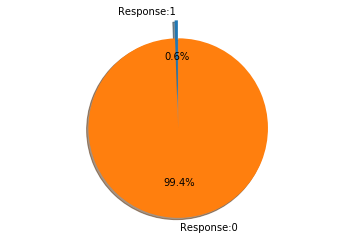

In [14]:
plt_pipe(counts_1_all_l[0].asDict())

In [14]:
counts_by_col = df_num2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
counts_by_col.limit(1).toPandas()

In [15]:
counts_by_col_l = counts_by_col.collect()

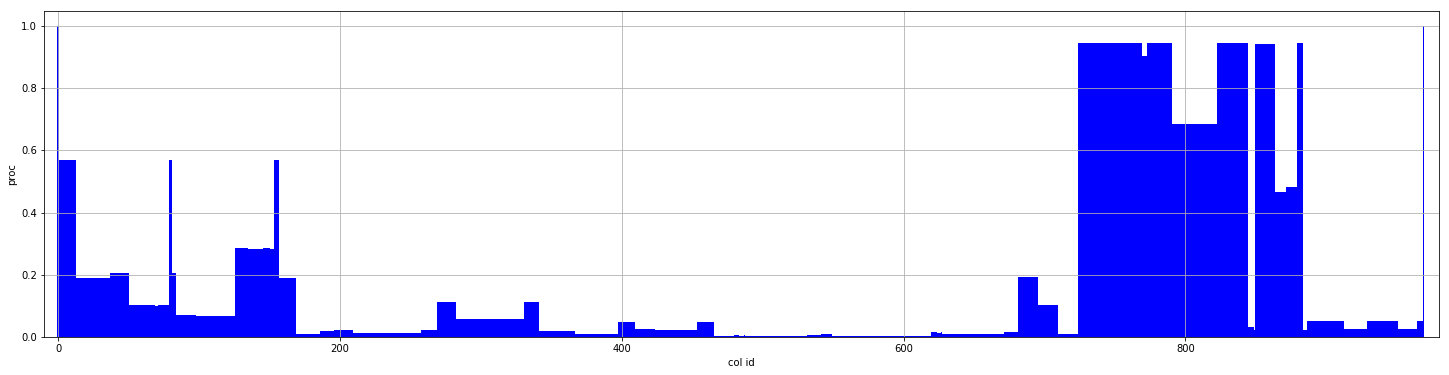

In [106]:
plt_hist(counts_by_col_l[0].asDict())

In [ ]:
col_with_resp = df_num2.filter(df_num2.Response == 1 ).select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
col_with_resp.limit(100).toPandas()

In [ ]:
col_with_resp_l = col_with_resp.collect()

In [ ]:
plt_hist(col_with_resp_l[0].asDict())

In [16]:
counts_by_col3 = df_date2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_date2.columns])

In [ ]:
counts_by_col3.limit(1).toPandas()

In [17]:
counts_by_col_l3 = counts_by_col3.collect()

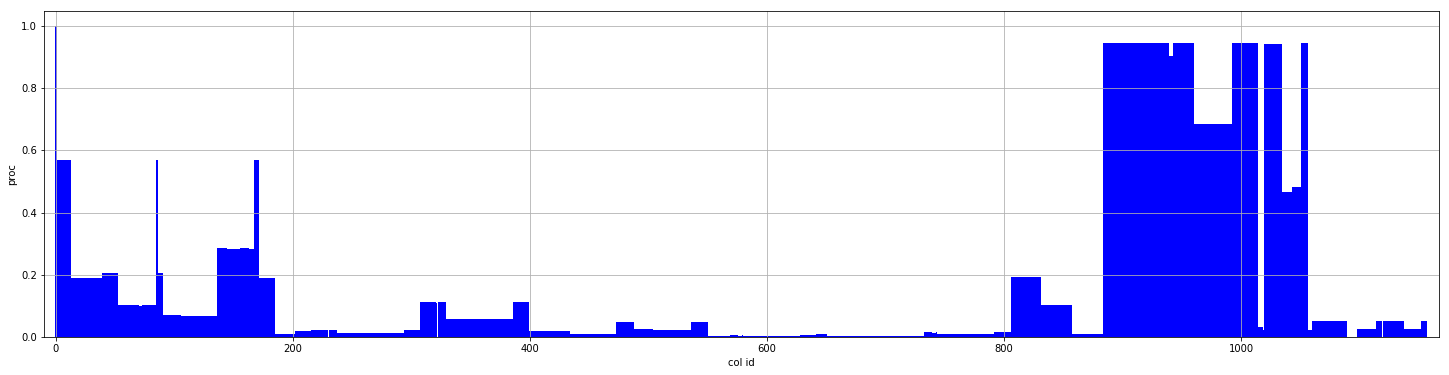

In [117]:
plt_hist(counts_by_col_l3[0].asDict())

In [18]:
counts_by_col4 = df_cat2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_cat2.columns])

In [19]:
counts_by_col_l4 = counts_by_col4.collect()

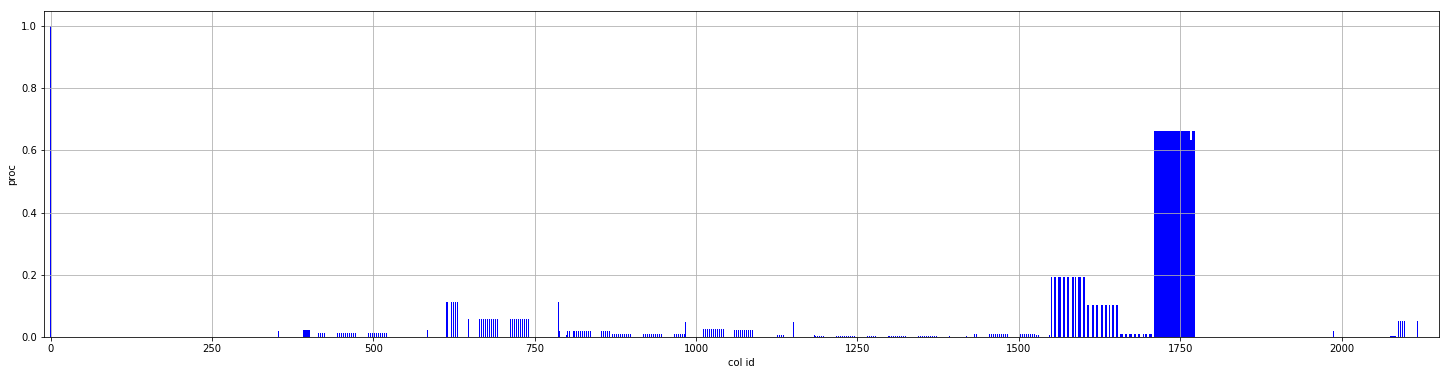

In [120]:
plt_hist(counts_by_col_l4[0].asDict())